In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5a096c8c-20f3-bd64-4af8-96962cdda239)


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
DIR_PATH ='/content/drive/MyDrive/vegetables_leaf/vegetables_dataset'

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=128):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [5]:
for dirpath, dirnames, filenames in os.walk(DIR_PATH):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset'.
There are 3 directories and 0 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/train'.
There are 0 directories and 1680 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/train/tomato'.
There are 0 directories and 1680 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/train/pepper'.
There are 0 directories and 1680 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/train/potato'.
There are 3 directories and 0 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/test'.
There are 0 directories and 420 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/test/tomato'.
There are 0 directories and 420 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/test/pepper'.
There are 0 directories and 420 images in '/content/drive/MyDrive/vegetables_leaf/vegetables_dataset/test

In [6]:
train_dir = DIR_PATH + "/train/"
test_dir = DIR_PATH+ "/test/"

In [7]:
import pathlib
import numpy as np
data_dir = pathlib.Path(test_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pepper' 'potato' 'tomato']


Image shape: (256, 256, 3)


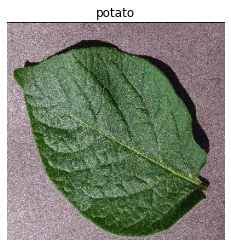

In [8]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(128, 128),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=42) # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True,
                                               seed=42)

Found 5040 images belonging to 3 classes.
Found 1260 images belonging to 3 classes.


In [10]:
len(train_data[0][1][0]), train_data[0][0].shape

(3, (32, 128, 128, 3))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

veg_leaf_model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(128, 128, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax') # changed to have 3 neurons (same as number of classes) and 'softmax' activation
])


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

veg_leaf_model_1.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_1 = veg_leaf_model_1.fit(train_data,
                          epochs=4,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/4
158/158 [==============================] - 1088s 7s/step - loss: 0.6922 - accuracy: 0.7067 - val_loss: 0.3300 - val_accuracy: 0.8690
Epoch 2/4
158/158 [==============================] - 18s 115ms/step - loss: 0.2276 - accuracy: 0.9214 - val_loss: 0.2303 - val_accuracy: 0.9167
Epoch 3/4
158/158 [==============================] - 18s 115ms/step - loss: 0.1502 - accuracy: 0.9470 - val_loss: 0.2706 - val_accuracy: 0.8976
Epoch 4/4
158/158 [==============================] - 18s 116ms/step - loss: 0.1258 - accuracy: 0.9597 - val_loss: 0.1399 - val_accuracy: 0.9444


In [13]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

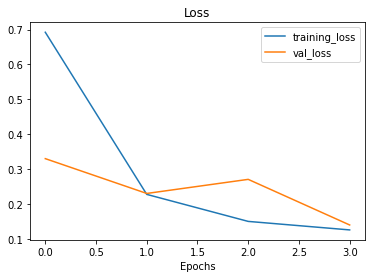

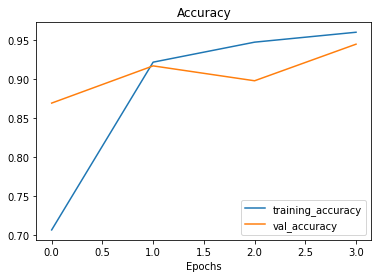

In [14]:
plot_loss_curves(history_1)

In [15]:
veg_leaf_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dense (Dense)               (None, 3)                 2

In [16]:
veg_leaf_model_1.evaluate(test_data)

40/40 [==============================] - 4s 91ms/step - loss: 0.1399 - accuracy: 0.9444


[0.13994374871253967, 0.9444444179534912]

In [17]:
veg_leaf_model_1.save("veg_leaf_classification_model.h5")

In [18]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = veg_leaf_model_1.predict(test_data)

40/40 [==============================] - 4s 89ms/step


In [19]:
predictions.shape

(1260, 3)

In [20]:
predictions[0]

array([3.5318802e-04, 9.9928892e-01, 3.5781576e-04], dtype=float32)

In [21]:
predictions[0].argmax(), class_names, test_data.classes

(1,
 array(['pepper', 'potato', 'tomato'], dtype='<U6'),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int32))

In [22]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))


Confusion Matrix
[[123 154 143]
 [132 149 139]
 [131 149 140]]


In [23]:
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=class_names))


Classification Report
              precision    recall  f1-score   support

      pepper       0.32      0.29      0.31       420
      potato       0.33      0.35      0.34       420
      tomato       0.33      0.33      0.33       420

    accuracy                           0.33      1260
   macro avg       0.33      0.33      0.33      1260
weighted avg       0.33      0.33      0.33      1260



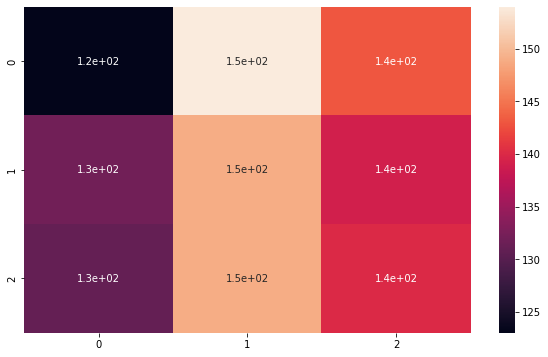

In [24]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_data.classes, y_pred),annot=True)
# https://github.com/matplotlib/matplotlib/issues/14751

In [2]:
import tensorflow as tf
load_model = tf.keras.models.load_model('/content/veg_leaf_classification_model.h5')

In [4]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 26ms/step


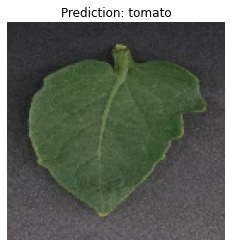

In [14]:
pred_and_plot(load_model, "/content/drive/MyDrive/vegetables_leaf/test_images/TomatoHealthy2.JPG", class_names)